In [752]:
%matplotlib inline

In [753]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

Utility functions:

In [754]:
def get_state_abbr(x: str):
    """
    Get the abbrevation from a "County, ST" string.
    
    >>> get_state_abbr("Collier, FL")
    'FL'
    
    """
    if pd.isna(x):
        return None
    if ", " in x:
        return x.split(", ")[1]
    return None

# Get data and preprocess:

In [768]:
# Download population and abbreviation data to map density / popn info to reports:

# state_popn = pd.read_html("./List of States By Population Density.html", header=0)[2:][0]
# state_abbr = pd.read_html("./State Abbreviations and State Postal Codes.html", header=0)[0]
state_popn.to_csv("StatePopulations.csv")
state_abbr.to_csv("StateAbbreviations.csv")

# Download latest csse data:
df = pd.read_csv(
    "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data"
    "/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
)
df['state_abbr'] = df['Province/State'].map(get_state_abbr)

# Join density/popn to reports:
state_info = state_popn.set_index("State Name").join(state_abbr.set_index("State"))
# Join state abbreviation info
state_confirmed = df.groupby("state_abbr").sum().join(state_info.set_index("Postalcode"))

In [769]:
# Get a list of columns which correspond to the timeseries:
date_cols = [c for c in state_confirmed.columns if '/20' in c]

# Normalize to density:
state_confirmed_div_density = state_confirmed[date_cols].div(
    state_confirmed['Population Density'], axis='rows'
)

# Normalize to state population:
state_confirmed_div_population = state_confirmed[date_cols].div(
    state_confirmed['Population'], axis='rows'
)

# Print diagnostic:
print("Data available through", date_cols[-1])

Data available through 3/15/20


In [770]:
def plot_states(
    states=state_confirmed.index, 
    show_legend=True, 
    scale: float = 3, 
    save_path = None, 
    data_src=None
):
    """
    Plot a timeseries chart of confirmed cases over time.
    
    Arguments:
        states (List[str]): The list of states to render. Defaults to all states.
        show_legend (Union[bool, List[str]]): A boolean or list of states to show.
            If False, render no legend.
            If True, render all states included in `states` argument
            If a list of states, render only these states in color, and the others
                in greyscale.
        scale (float: 3): The figure size (3 is a nice res for Twitter)
        save_path (str): The path to write to. If None, will not save figure.
    """
    data_src = data_src or state_confirmed_div_population
    
    with plt.style.context("fivethirtyeight"):

        plt.figure(figsize=(4*scale, 3*scale))
        for state in states:
            _data = data_src.loc[state]
            _data = _data[_data>0]
            if isinstance(show_legend, list) or show_legend is True:
                if show_legend is True or state in show_legend:
                    plt.plot(
                        [pd.Timestamp(k) for k in _data.keys()], 
                        _data.values, label=state
                    )
                else:
                    plt.plot(
                        [pd.Timestamp(k) for k in _data.keys()], 
                        _data.values, label=None, color='#ffffff', 
                        alpha=0.7
                    )
            else:
                plt.plot(
                    [pd.Timestamp(k) for k in _data.keys()], 
                    _data.values, label=None
                )
                    
        plt.ylabel("Fraction of Total Population")
        plt.yscale("log")
        plt.axhspan(0.1, 1.0, alpha=0.3)
        plt.axhspan(0.01, 0.1, alpha=0.1)
        plt.text(pd.Timestamp("03/01/20"), 1.0, "100%")
        plt.text(pd.Timestamp("03/01/20"), 0.1, "10%")
        plt.text(pd.Timestamp("03/01/20"), 0.01, "1%")
        if show_legend != False:
            plt.legend()
        plt.title("Total Confirmed Coronavirus Cases (% of State Population)")
        plt.suptitle(date_cols[-1])
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()

            
millis_per_day = 60*60*24*1000*1000*1000
def _get_dataset_doubling_period(dataset):
    dataset = dataset[dataset.values > 3]
    if len(dataset) == 0 or np.Inf in dataset or len(set(dataset)) < 2:
        return [0, 0]
    return np.polyfit(
        np.log(dataset.values), 
        (pd.to_datetime(dataset.keys()) - pd.to_datetime("Jan 1 2020")).astype(int)/(millis_per_day), 1
    )

def get_region_doubling_period(region: str):
    return np.round(_get_dataset_doubling_period(df[df['Country/Region'] == region][date_cols].sum())[0], 2)

def get_state_doubling_period(region: str):
    return np.round(_get_dataset_doubling_period(df[df['Province/State'] == region][date_cols].sum())[0], 2)

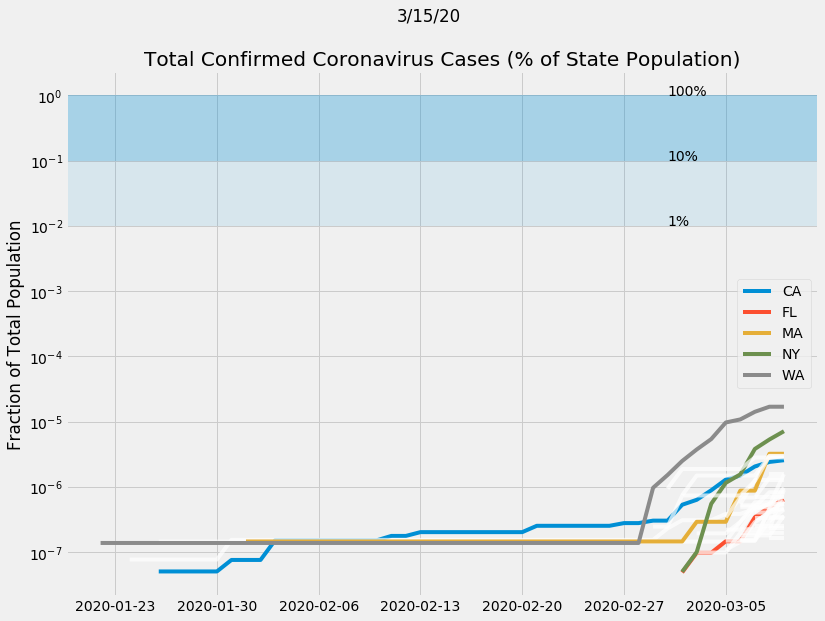

In [771]:
plot_states(show_legend=['CA', 'NY', 'MA', "WA", "FL"], save_path=date_cols[-1].replace("/", "-"))

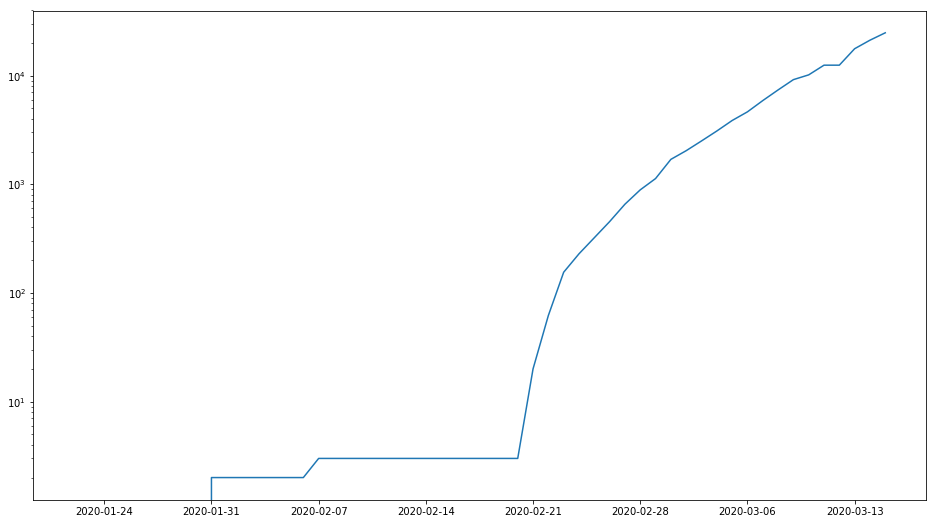

In [772]:
def __italy():
    _data = df[df['Country/Region'] == 'Italy'][date_cols].iloc[0]
    plt.figure(figsize=(16, 9))
    plt.plot(
        [pd.Timestamp(k) for k in _data.keys()], 
        _data.values
    )
    plt.yscale("log")
__italy()

# Doubling Times of States

In [773]:
doubling_periods = pd.DataFrame([{
    "state": state,
    "doubling_time": get_state_doubling_period(state),
    "total": df[df['Province/State'] == state][date_cols].sum().max()
    
} for state in state_abbr['State']])

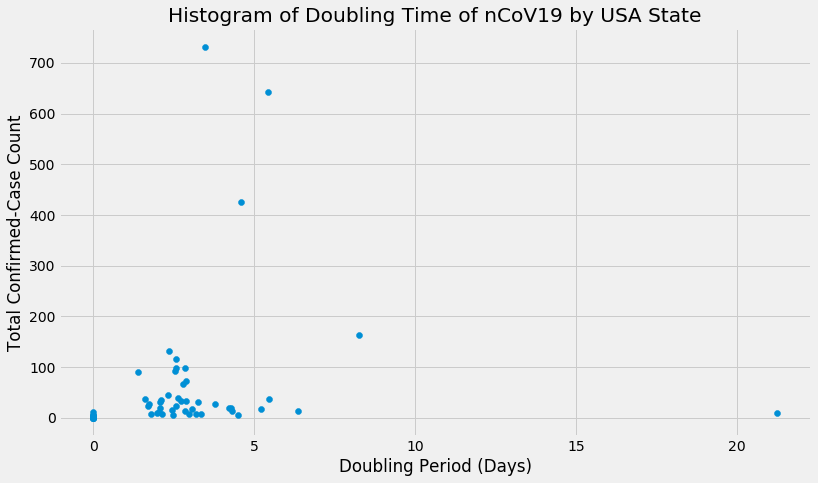

In [774]:
with plt.style.context("fivethirtyeight"):
    plt.figure(figsize=(12, 7))
    plt.title("Histogram of Doubling Time of nCoV19 by USA State")
    plt.ylabel("Total Confirmed-Case Count")
    plt.xlabel("Doubling Period (Days)")
    plt.scatter(doubling_periods["doubling_time"], doubling_periods["total"])

In [775]:
df[df['Province/State'].str.contains('MD', na=False)]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,state_abbr
238,"Prince George's, MD",US,38.7849,-76.8721,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MD
264,"Harford County, MD",US,39.5839,-76.3637,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,MD
322,"Montgomery County, MD",US,39.1547,-77.2405,0,0,0,0,0,0,...,3,4,4,0,0,0,0,0,0,MD
